<a href="https://colab.research.google.com/github/capozzolicaluan/MSWEPtest/blob/main/spatial_analyst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Limpar todas as variáveis
from IPython import get_ipython
get_ipython().magic('reset -sf')


In [2]:
# Importando as bibliotecas necessárias
import requests
import pandas as pd
import gc
from google.colab import data_table
import math
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point


# Liberar memória manualmente
_ = gc.collect()

In [3]:
def uneDataframes(df1, df2):

  df_completo = pd.concat([df1, df2], axis=1)

  if df_completo.shape[1] == 4:
    df_completo.columns = ['Estacao', 'Latitude', 'Longitude', 'Anual']
  elif df_completo.shape[1] == 15:
    df_completo.columns = ['Estacao','Latitude', 'Longitude','Jan','Feb','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez']
  else:
    print("Número de colunas não suportado")
    return

  return df_completo

In [15]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [5]:
from posixpath import join
file_path = "/content/drive/MyDrive/Colab/txts"

In [6]:
estacoes_lat_lon = pd.read_csv(join(file_path, "estacoes_lat_lon.txt"), sep = ';', header=None)

# Assigning column names to estacoes_lat_lon for clarity
estacoes_lat_lon.columns = ['Estacao', 'Latitude', 'Longitude']

In [7]:
lista_arquivos = os.listdir(join(file_path,"error_result"))

In [ ]:
erros_dicionario.keys()

dict_keys(['erro_rmse_mes', 'erro_rmse', 'erro_pod_mes', 'erro_csi_mes', 'erro_far', 'erro_far_mes', 'erro_csi', 'erro_pod', 'erro_cc_mes', 'erro_bias_mes', 'erro_cc', 'erro_bias'])

In [8]:
erros_dicionario = {}

for arquivo in lista_arquivos:
  erro_df = pd.read_csv(join(file_path,"error_result",arquivo), sep = ';')

  erro_df_final = uneDataframes(df1=estacoes_lat_lon, df2=erro_df)

  nome_base = os.path.splitext(arquivo)[0]

  # Adiciona ao dicionário
  erros_dicionario[nome_base] = erro_df_final

In [9]:
# prompt: fazer uma lista com os nomes das chaves dos dicionarios do erros_dicionario

nomes_chaves = list(erros_dicionario.keys())
nomes_chaves


['erro_cc_mes',
 'erro_bias_mes',
 'erro_rmse_mes',
 'erro_far_mes',
 'erro_pod_mes',
 'erro_csi_mes',
 'erro_cc',
 'erro_rmse',
 'erro_pod',
 'erro_csi',
 'erro_far',
 'erro_bias']

In [13]:
df = erros_dicionario[nomes_chaves[6]]
df

,Estacao,Latitude,Longitude,Anual
0,58040000,-23.2386,-45.3067,0.314674
1,58204000,-22.8119,-45.1825,0.481092
2,58183000,-22.9117,-45.4700,0.514573
3,58380001,-22.1628,-43.2864,0.550797
4,58405000,-22.3319,-43.1317,NaN
5,58520000,-21.9667,-43.3744,0.498056
6,58530000,-22.2708,-44.3900,0.438216
7,58550001,-22.0861,-43.8200,0.349539
8,58585000,-22.0844,-43.5589,0.542127
9,58680001,-21.6658,-42.0811,0.470221


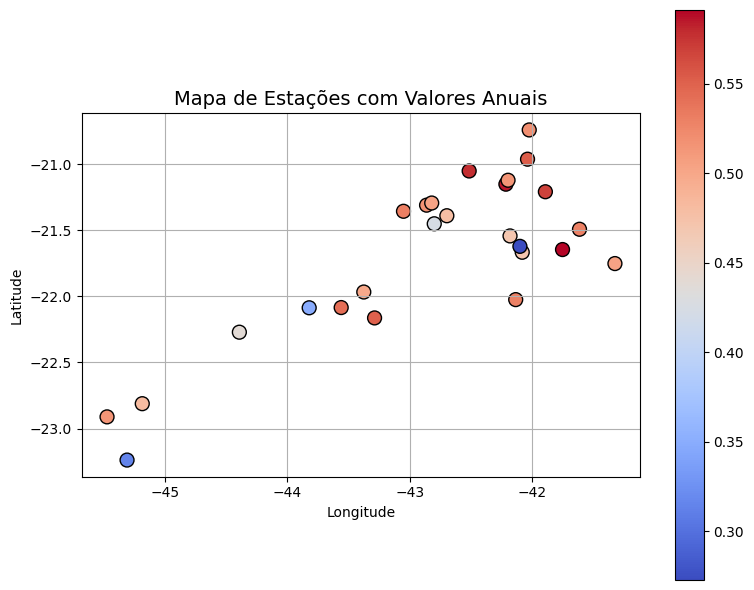

In [14]:
# Criar GeoDataFrame com geometria de pontos
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']),
    crs="EPSG:4326"
)

# Plotar
fig, ax = plt.subplots(figsize=(8, 6))
gdf.plot(
    ax=ax,
    column='Anual',
    cmap='coolwarm',      # cores azul-vermelho
    legend=True,
    markersize=100,
    edgecolor='black'
)

ax.set_title("Mapa de Estações com Valores Anuais", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
plt.tight_layout()
plt.show()